# NSGA-II and ZDT tests
These is the [Deap](https://github.com/DEAP/deap/tree/f6accf730555c5bbc1c50ac310250ad707353080) implementation of the algorithm NSGA-II. I have just made a example file executing the Zitzler et al. tests.

The documentation of the library can be found [here](https://deap.readthedocs.io/en/master/) and the code for the benchmarck function ZDT, [here](https://github.com/DEAP/deap/blob/f6accf730555c5bbc1c50ac310250ad707353080/deap/benchmarks/__init__.py)

In [1]:
import array
import random
import json

import numpy

from math import sqrt

from deap import algorithms
from deap import base
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
from deap import creator
from deap import tools

In [2]:
from pprint import pprint

# Uncomment this to debugg the code
# import pixiedust

In [3]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", array.array, typecode='d', fitness=creator.FitnessMin)


In [4]:
toolbox = base.Toolbox()


In [5]:
# Problem definition
# Functions zdt1, zdt2, zdt3, zdt6 have bounds [0, 1]
BOUND_LOW, BOUND_UP = 0.0, 1.0

# Functions zdt4 has bounds x1 = [0, 1], xn = [-5, 5], with n = 2, ..., 10
# BOUND_LOW, BOUND_UP = [0.0] + [-5.0]*9, [1.0] + [5.0]*9

# Functions zdt1, zdt2, zdt3 have 30 dimensions, zdt4 and zdt6 have 10
NDIM = 30

def uniform(low, up, size=None):
    try:
        return [random.uniform(a, b) for a, b in zip(low, up)]
    except TypeError:
        return [random.uniform(a, b) for a, b in zip([low] * size, [up] * size)]

In [6]:
toolbox.register("attr_float", uniform, BOUND_LOW, BOUND_UP, NDIM)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_float)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", (lambda indi: benchmarks.zdt1(indi)))
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=20.0, indpb=1.0/NDIM)
toolbox.register("select", tools.selNSGA2)

In [7]:

def main(seed=None):
    cont = 0
    random.seed(seed)
    # Number of generations / iterations of the process
    NGEN = 250
    # Popuation size
    MU = 100
    # Cross-over probability
    CXPB = 0.9

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    # stats.register("avg", numpy.mean, axis=0)
    # stats.register("std", numpy.std, axis=0)
    stats.register("min", numpy.min, axis=0)
    stats.register("max", numpy.max, axis=0)
    
    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "std", "min", "avg", "max"
    
    pop = toolbox.population(n=MU)

    # Evaluate the individuals to assign fitness
    invalid_ind = [ind for ind in pop if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # This is just to assign the crowding distance to the individuals
    # no actual selection is done
    pop = toolbox.select(pop, len(pop))
    
    record = stats.compile(pop)
    logbook.record(gen=0, evals=len(invalid_ind), **record)
    # print(logbook.stream)

    # Begin the generational process
    for gen in range(1, NGEN):
        # Vary the population
        offspring = tools.selTournamentDCD(pop, len(pop))
        offspring = [toolbox.clone(ind) for ind in offspring]
        
        for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
            # Check cross-over probability
            if random.random() <= CXPB:
                toolbox.mate(ind1, ind2)
            
            toolbox.mutate(ind1)
            toolbox.mutate(ind2)
            
            # Reset chromoseome's fitnesses
            del ind1.fitness.values, ind2.fitness.values
        
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        
        # Re-assign fitnesses to chromosomes
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Select the next generation population
        pop = toolbox.select(pop + offspring, MU)
        
        # if cont == 0:
        #     pprint('The CD is: {}'.format(pop[0].fitness.crowding_dist))
        #     pprint('The D is: {}'.format(pop[0].fitness.dominates))
        #     pprint(pop[0].fitness.values)
        #     cont+=1
            
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(invalid_ind), **record)
        # print(logbook.stream)

    print("Final population hypervolume is %f" % hypervolume(pop, [11.0, 11.0]))

    return pop, logbook

In [8]:
with open("pareto_front/zdt1_front.json") as optimal_front_data:
    optimal_front = json.load(optimal_front_data)
    #Use 500 of the 1000 points in the json file
    optimal_front = sorted(optimal_front[i] for i in range(0, len(optimal_front), 2))

In [9]:
# %%pixie_debugger

pop, stats = main()

Final population hypervolume is 120.652820


In [10]:
pop.sort(key=lambda x: x.fitness.values)

# print(stats)
# Calculate convergence and diversity compared with the "optimal_front" 
print("Convergence: ", convergence(pop, optimal_front))
print("Diversity: ", diversity(pop, optimal_front[0], optimal_front[-1]))

Convergence:  0.0016744147140239699
Diversity:  0.367382984076487


In [11]:
import matplotlib.pyplot as plt
import numpy

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

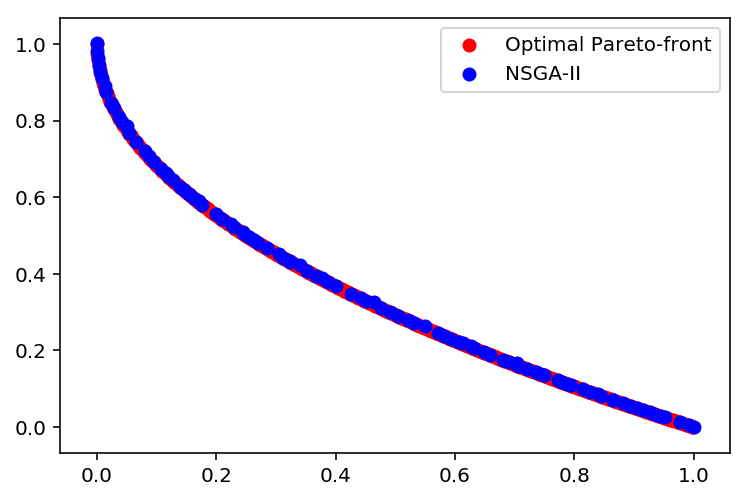

In [13]:
front = numpy.array([ind.fitness.values for ind in pop])

optimal_front = numpy.array(optimal_front)
plt.scatter(optimal_front[:,0], optimal_front[:,1], c="r")
plt.scatter(front[:,0], front[:,1], c="b")
plt.legend(('Optimal Pareto-front','NSGA-II'), loc = 'upper right')
plt.axis("tight")
plt.show()
